# Jax-Bayes MNIST Example --- Traditional Optimization Approach
To run on Colab, just run the cells sequentially
## Setup the Environment

In [ ]:
#see https://github.com/google/jax#pip-installation
!pip install --upgrade https://storage.googleapis.com/jax-releases/cuda101/jaxlib-0.1.51-cp36-none-manylinux2010_x86_64.whl
!pip install --upgrade jax
!pip install git+https://github.com/deepmind/dm-haiku
#you may have to retart your runtime and re-run this due to dependency conflict
# with pre-installed tensorflow.
!pip install git+https://github.com/jamesvuc/jax-bayes

In [2]:
import haiku as hk

import jax.numpy as jnp
from jax.experimental import optimizers
import jax

import jax_bayes

import sys, os, math, time
import numpy as onp

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow_datasets as tfds

## Loat Data and Create the Model

In [4]:
def load_dataset(split, is_training, batch_size):
	ds = tfds.load('mnist:3.*.*', split=split).cache().repeat()
	if is_training:
		ds = ds.shuffle(10 * batch_size, seed=0)
	ds = ds.batch(batch_size)
	return tfds.as_numpy(ds)

def net_fn(batch):
	""" 
  Standard LeNet-300-100 MLP 
	"""
	x = batch["image"].astype(jnp.float32) / 255.
	mlp = hk.Sequential([
		hk.Flatten(),
		hk.Linear(300), jax.nn.relu, 
		hk.Linear(100), jax.nn.relu, 
		hk.Linear(10)])

	return mlp(x)

## Build the Optimizer, Loss, Accuracy, and Train Step

In [5]:
# hyperparameters
lr = 1e-3
reg = 1e-4

# haiku.transform turns the function into a 'haiku.Transformed' object
# with init(...) and apply(...) methods.
net = hk.transform(net_fn)

#this is the closest to the rms_langevin algorithm
opt_init, opt_update, opt_get_params = optimizers.rmsprop(lr)

def loss(params, batch):
  logits = net.apply(params, None, batch)
  labels = jax.nn.one_hot(batch['label'], 10)

  l2_loss = 0.5 * sum(jnp.sum(jnp.square(p)) 
            for p in jax.tree_leaves(params))
  
  softmax_crossent = - jnp.mean(labels * jax.nn.log_softmax(logits))

  return softmax_crossent + reg * l2_loss

@jax.jit
def accuracy(params, batch):
  preds = net.apply(params, None, batch)
  return jnp.mean(jnp.argmax(preds, axis=-1) == batch['label'])

@jax.jit
def train_step(i, opt_state, batch):
  params = opt_get_params(opt_state)
  dx = jax.grad(loss)(params, batch)
  opt_state = opt_update(i, dx, opt_state)
  return opt_state

## Load Batch Iterators & Do the Optimization

In [15]:
# load the data into memory and create batch iterators
train_batches = load_dataset("train", is_training=True, batch_size=1_000)
val_batches = load_dataset("train", is_training=False, batch_size=10_000)
test_batches = load_dataset("test", is_training=False, batch_size=10_000)

In [12]:
%%time
# instantiate the model parameters --- requires a 'test batch' for tracing
params = net.init(jax.random.PRNGKey(42), next(train_batches))

# intialize the optimzier state
opt_state = opt_init(params)

# iterate 10_000 batches (way more than enough)
for step in range(10_001):
  if step % 1_000 == 0:
    params = opt_get_params(opt_state)
    val_acc = accuracy(params, next(val_batches))
    test_acc = accuracy(params, next(test_batches))
    print(f"step = {step}"
        f" | val acc = {val_acc:.3f}"
        f" | test acc = {test_acc:.3f}")
  
  opt_state = train_step(step, opt_state, next(train_batches))

step = 0 | val acc = 0.129 | test acc = 0.132
step = 1000 | val acc = 0.982 | test acc = 0.974
step = 2000 | val acc = 0.992 | test acc = 0.981
step = 3000 | val acc = 0.993 | test acc = 0.980
step = 4000 | val acc = 0.993 | test acc = 0.978
step = 5000 | val acc = 0.993 | test acc = 0.979
step = 6000 | val acc = 0.989 | test acc = 0.976
step = 7000 | val acc = 0.996 | test acc = 0.981
step = 8000 | val acc = 0.994 | test acc = 0.978
step = 9000 | val acc = 0.996 | test acc = 0.982
step = 10000 | val acc = 0.990 | test acc = 0.978
CPU times: user 59.5 s, sys: 10.6 s, total: 1min 10s
Wall time: 54.7 s


## Uncertainty Analysis

This will illustrate how logits perform when we use them to proxy uncertainty about predictions. We take the 10-class logits to be measure of uncertainty and measure
1. Accuracy for a given certainty threshold (i.e. P(predicted class > threshold));
2. Entropy of the predictive distribution (this measures "surprise" for a distribution); and
3. How accuracy changes as we increase certainty.

acc = 0.9785 | cert acc = 0.9828 | pct cert = 0.9923  | entropy = 0.0949 vs theoretical maximum 2.3026


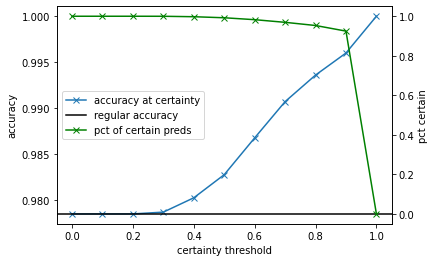

In [27]:
from jax_bayes.utils import entropy, certainty_acc

_batch = next(test_batches)

# proxy the posterior predictive by the logits
@jax.jit
def posterior_predictive(params, batch):
  logit_pp = net.apply(params, None, _batch)
  return jax.nn.softmax(logit_pp, axis=-1)

# evaluate the entropy of the posterior predictive
_batch = next(test_batches)
pp = posterior_predictive(params, _batch)
ent = jnp.mean(entropy(pp))
ent_upper_limit = float(entropy(jnp.ones((1,10))/10.))

# evaluate the accuracy and accuracy @ 50% certainty that the prediction is correct.
acc = accuracy(params, _batch)
cert_acc, cert_mask = certainty_acc(pp, _batch['label'], cert_threshold=0.5)

print(f"acc = {acc:.4f}"
      f" | cert acc = {cert_acc:.4f}"
      f" | pct cert = {cert_mask.mean():.4f} "
      f" | entropy = {ent:.4f} vs theoretical maximum {ent_upper_limit:.4f}")

# plot how accuracy changes as we increase the required level of certainty
thresholds = [0.1 * i for i in range(11)] 
cert_accs, pct_certs = [], []
for t in thresholds:
  cert_acc, cert_mask = certainty_acc(pp, _batch['label'], cert_threshold=t)
  cert_accs.append(cert_acc)
  pct_certs.append(cert_mask.mean())

from matplotlib import pyplot as plt
f, ax = plt.subplots(1)
line1 = ax.plot(thresholds, cert_accs, label='accuracy at certainty', marker='x')
line2 = ax.axhline(y=acc, label='regular accuracy', color='black')
ax.set_ylabel('accuracy')
ax.set_xlabel('certainty threshold')

axb = ax.twinx()
line3 = axb.plot(thresholds, pct_certs, label='pct of certain preds', 
                 color='green', marker='x')
axb.set_ylabel('pct certain')

lines = line1 + [line2] + line3
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc=6)

plt.show()

This shows that the model is very 'certain' about all the predictions it makes. This is reasonable, given its high accuracy. We do see the accuracy improve as we ask the model to be more certain, which is desirable. 

**However** a good property of uncertainty is that it should *increase* outside the training distribution. What about if we evaluate ***the same model*** on FashionMNIST?

## Uncertainty Evaluation Out of Distribution

acc = 0.0608 | entropy = 0.0949 vs theoretical maximum 2.3026


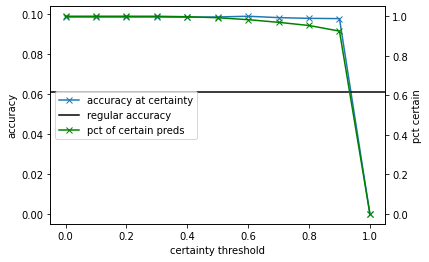

In [33]:
fashion_ds = tfds.load('fashion_mnist:3.*.*', split="test").cache().repeat()
fashion_test_batches = tfds.as_numpy(fashion_ds.batch(10_000))

fashion_batch = next(fashion_test_batches)
fa_pp = posterior_predictive(params, fashion_batch)
fa_acc = accuracy(params, fashion_batch)
fa_ent = jnp.mean(entropy(fa_pp))

print(f"acc = {fa_acc:.4f}"
      f" | entropy = {fa_ent:.4f} vs theoretical maximum {ent_upper_limit:.4f}")

thresholds = [0.1 * i for i in range(11)] 
fa_cert_accs, fa_pct_certs = [], []
for t in thresholds:
  fa_cert_acc, fa_cert_mask = certainty_acc(fa_pp, fashion_batch['label'], cert_threshold=t)
  fa_cert_accs.append(fa_cert_acc)
  fa_pct_certs.append(fa_cert_mask.mean())

f, ax = plt.subplots(1)
line1 = ax.plot(thresholds, fa_cert_accs, label='accuracy at certainty', marker='x')
line2 = ax.axhline(y=fa_acc, label='regular accuracy', color='black')
ax.set_ylabel('accuracy')
ax.set_xlabel('certainty threshold')

axb = ax.twinx()
line3 = axb.plot(thresholds, fa_pct_certs, label='pct of certain preds', 
                 color='green', marker='x')
axb.set_ylabel('pct certain')

lines = line1 + [line2] + line3
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc=6)

plt.show()

This is not good! The predictive entropy is approximately the same for FashionMNIST as for MNIST, despite the model never having seen a FashionMNIST example! Surely the model should be surprised by these examples.

To make matters worse, this plot says that model is 80% certain about ~90% of its predictions, despite these predictions being ~ 8% accurate.

## Conclusion: Logits != Uncertainty